チャープしたグレーティング周期

$$
\Lambda(z) = \frac {\Lambda_{0}} {(1 + rz)}
$$

において、$i$ 番目のグレーティングで積分を行う時、その幅を知る必要がある。

逐次的に幅を加算していく方法は計算に時間がかかり、丸め誤差も発生する。

これを解決する方法。

以下のように考えられます。

元の処理では、各ステップで  
$$
\text{width} = \frac{\text{start\_width}}{1 + \text{chirp\_rate} \cdot z}
$$
と計算し、zを累積していました。つまり、  
$$
z_0 = 0,\quad z_{i+1} = z_i + \frac{\text{start\_width}}{1 + \text{chirp\_rate} \cdot z_i}
$$
という再帰関係になっています。

この離散的な更新を連続版に近似して、$i$を連続変数とみなすと、  
$$
\frac{dz}{di} = \frac{\text{start\_width}}{1 + \text{chirp\_rate} \cdot z}
$$
となります。ここで変数分離を行います。

1. 両辺を $1 + \text{chirp\_rate} \cdot z$ で掛けて  
   $$
   (1 + \text{chirp\_rate} \cdot z) \, dz = \text{start\_width} \, di
   $$
2. $z=0$ から $z=z_i$ まで、$i=0$ から $i=i$ まで積分すると、
   $$
   \int_0^{z_i} (1 + \text{chirp\_rate} \cdot z) \, dz = \text{start\_width} \int_0^i di
   $$
   左辺は簡単に積分でき、  
   $$
   z_i + \frac{\text{chirp\_rate}}{2} z_i^2 = \text{start\_width} \cdot i
   $$
3. これを $z_i$ について解くと、2次方程式  
   $$
   \text{chirp\_rate} \, z_i^2 + 2 \, z_i - 2 \, \text{start\_width} \, i = 0
   $$
   が得られます。このうち正の解（物理的に意味のある解）は
   $$
   z_i = \frac{\sqrt{1 + 2\,\text{chirp\_rate}\,\text{start\_width}\,i} - 1}{\text{chirp\_rate}}
   $$
4. もともとの幅の式  
   $$
   \text{width}_i = \frac{\text{start\_width}}{1 + \text{chirp\_rate} \cdot z_i}
   $$
   に $z_i$ の式を代入すると、
   $$
   \text{width}_i = \frac{\text{start\_width}}{1 + \text{chirp\_rate} \cdot \frac{\sqrt{1 + 2\,\text{chirp\_rate}\,\text{start\_width}\,i} - 1}{\text{chirp\_rate}}}
   = \frac{\text{start\_width}}{\sqrt{1 + 2\,\text{chirp\_rate}\,\text{start\_width}\,i}}
   $$
となります。

この結果、各インデックス $i$ に対する幅は  
$$
\text{width}_i = \frac{\text{start\_width}}{\sqrt{1 + 2\,\text{chirp\_rate}\,\text{start\_width}\,i}}
$$
と解析的に直接求められます。この形ならば、各 $i$ に対する計算は独立して並列に行えます。

(100, 2)


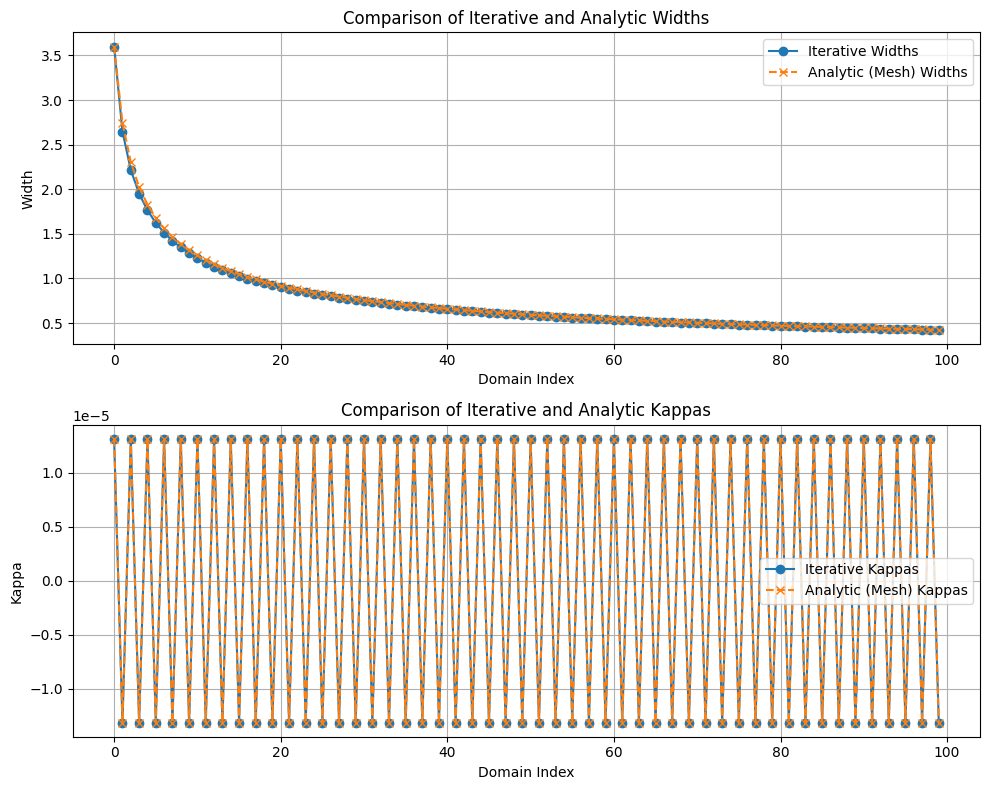

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from syuron import pp


def chirped_superlattice_iterative(n_domains, start_width, kappa_val, chirp_rate=0.0):
    widths = []
    z = 0.0
    for i in range(n_domains):
        w = start_width / (1 + chirp_rate * z)
        widths.append(w)
        z += w
    kappas = np.array([kappa_val if i % 2 == 0 else -
                      kappa_val for i in range(n_domains)])
    return np.array(widths), kappas


n_domains = 100
start_width_dim = [3.6]       # List[float]
chirp_rate_dim = [0.1]       # List[float]
kappa_val = 1.31E-05

width_tensor = pp.chirped(
    n_domains, start_width_dim, kappa_val, chirp_rate_dim)

analytic_tensor = np.squeeze(np.array(width_tensor), axis=(1, 2))
print(analytic_tensor.shape)
analytic_widths = analytic_tensor[:, 0]
analytic_kappas = analytic_tensor[:, 1]

iterative_widths, iterative_kappas = chirped_superlattice_iterative(
    n_domains, start_width_dim[0], kappa_val, chirp_rate_dim[0])

indices = np.arange(n_domains)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(indices, iterative_widths,
            label='Iterative Widths', marker='o', linestyle='-')
axs[0].plot(indices, analytic_widths,
            label='Analytic (Mesh) Widths', marker='x', linestyle='--')
axs[0].set_title('Comparison of Iterative and Analytic Widths')
axs[0].set_xlabel('Domain Index')
axs[0].set_ylabel('Width')
axs[0].legend()
axs[0].grid(True)

# Plot kappas comparison
axs[1].plot(indices, iterative_kappas,
            label='Iterative Kappas', marker='o', linestyle='-')
axs[1].plot(indices, analytic_kappas,
            label='Analytic (Mesh) Kappas', marker='x', linestyle='--')
axs[1].set_title('Comparison of Iterative and Analytic Kappas')
axs[1].set_xlabel('Domain Index')
axs[1].set_ylabel('Kappa')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()